In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn.functional as F
torch.manual_seed(0)

from scripts.utils import pref_load


from scripts.model import getPolicy
import pickle

import torch
import torch.nn.functional as F
import copy


%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'Acrobot-v1'

env = gym.make(ENV_NAME)

K = 10

POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_both.pth"
pref_data = pref_load(f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Beta= 0.1


/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epoch:  1 loss= 0.6931471824645996 , mean return= -164.33333333333334
Epoch:  2 loss= 0.49849456548690796 , mean return= -135.0
Epoch:  3 loss= 0.34288322925567627 , mean return= -132.0
Epoch:  4 loss= 0.2277865707874298 , mean return= -138.0
Epoch:  5 loss= 0.14871981739997864 , mean return= -132.33333333333334
Epoch:  6 loss= 0.0973052829504013 , mean return= -152.66666666666666
Epoch:  7 loss= 0.06479155272245407 , mean return= -164.66666666666666
Epoch:  8 loss= 0.04427642002701759 , mean return= -100.0
Epoch:  9 loss= 0.031167015433311462 , mean return= -176.33333333333334
Epoch:  10 loss= 0.0226117130368948 , mean return= -106.0
Epoch:  11 loss= 0.016865253448486328 , mean return= -113.66666666666667
Epoch:  12 loss= 0.012894337996840477 , mean return= -121.66666666666667
Epoch:  13 loss= 0.010081306099891663 , mean return= -94.33333333333333
Epoch:  14 loss= 0.008039784617722034 , mean return= -104.33333333333333
Epoch:  15 loss= 0.006527740508317947 , mean return= -99.666666666

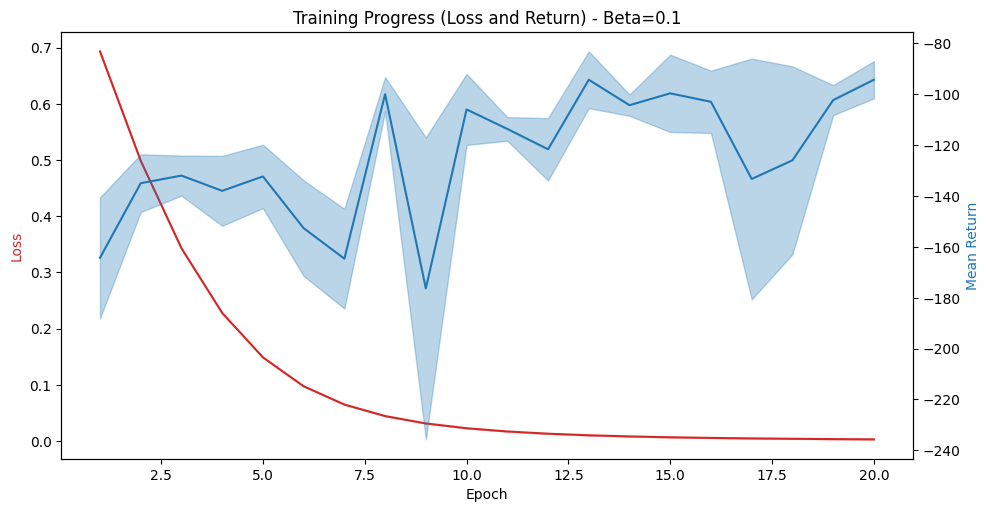

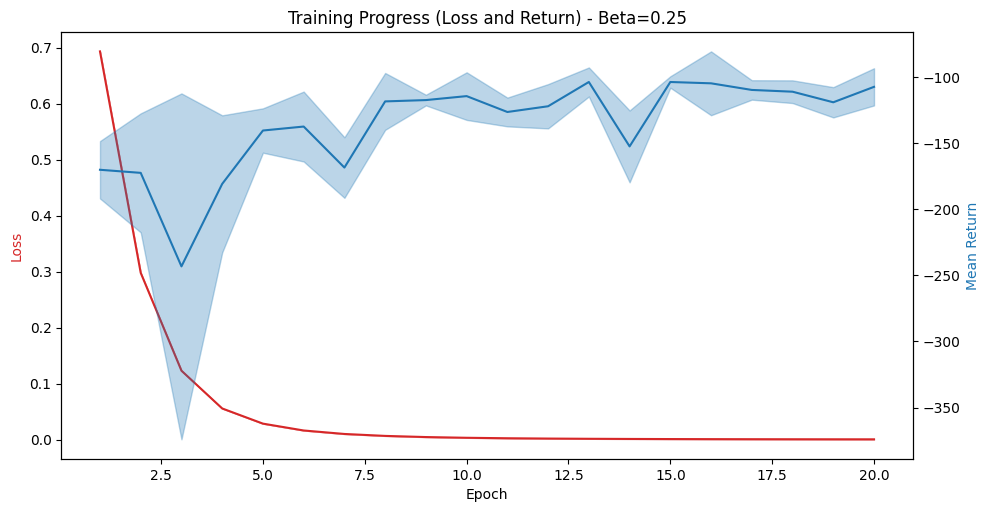

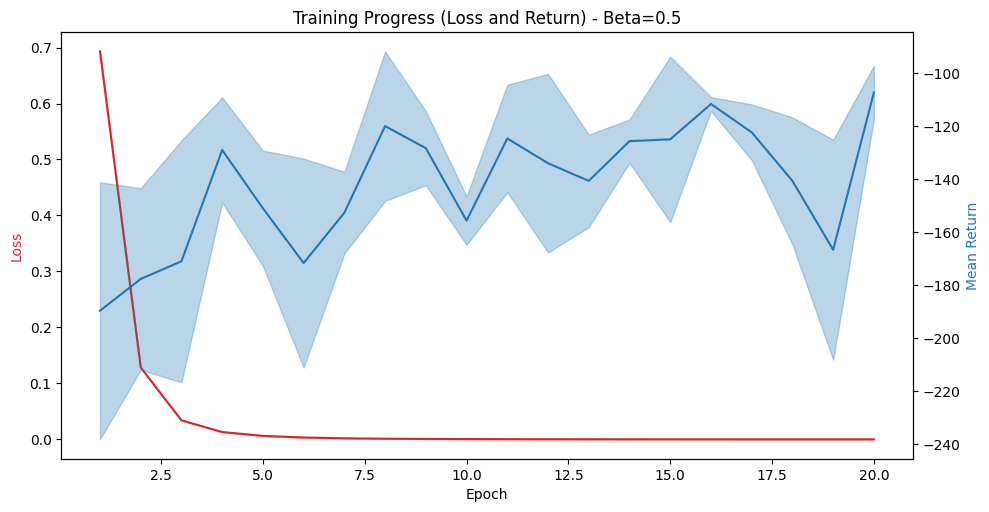

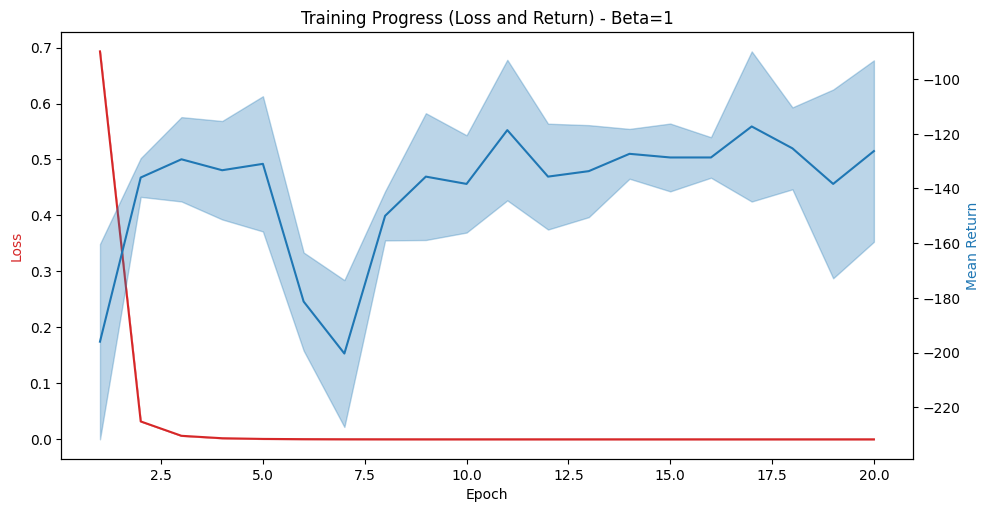

In [3]:
def trajectory_logprob(pi, states, actions):
    logp = torch.tensor(0., device=device)
    for s, a in zip(states, actions):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        probs = pi(s_t.unsqueeze(0)).squeeze(0)
        logp += torch.log(probs[a])
    return logp

def copyPolicy(policy):
    pi_ref = copy.deepcopy(policy).to(device)

    for p in pi_ref.parameters():
        p.requires_grad = False

    return pi_ref

mean_returns_betas = {}
std_returns_betas = {}
colors = ["orange", "blue", "green", "red"]
betas = [0.1, 0.25, 0.5, 1]
for beta in betas:

    #beta      = 0.1
    lr        = 5e-3
    epochs    = 20
    print("Beta=", beta)

    policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
    policy1.load_state_dict(torch.load(POLICY1_NAME, map_location=torch.device("cpu")))

    policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
    policy2.load_state_dict(torch.load(POLICY2_NAME, map_location=torch.device("cpu")))

    policy = copy.deepcopy(policy2).to(device)
    pi_ref = copyPolicy(policy)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    losses = []
    mean_returns = []
    std_returns = []

    random.seed(42)

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        
        for s0, tau_plus, tau_minus in pref_data:
            logp_pos = trajectory_logprob(policy, tau_plus["states"], tau_plus["actions"])
            logp_neg = trajectory_logprob(policy, tau_minus["states"], tau_minus["actions"])
            logp_ref_pos = trajectory_logprob(pi_ref, tau_plus["states"], tau_plus["actions"])
            logp_ref_neg = trajectory_logprob(pi_ref, tau_minus["states"], tau_minus["actions"])

            diff = beta * (logp_pos - logp_ref_pos) - beta * (logp_neg - logp_ref_neg)
            total_loss += -F.logsigmoid(diff)
        
        total_loss = total_loss / len(pref_data)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_value = total_loss.detach().numpy().item()
        losses.append(loss_value)
        
        returns = []
        for _ in range(3):
            seed = random.randint(0, 100000)
            state, done, total_r = env.reset(seed=seed), False, 0.0
            while not done:
                with torch.no_grad():
                    action, _ = policy.act(state)
                state, r, done, _ = env.step(action)
                total_r += r
            returns.append(total_r)

        returns = np.array(returns)
        mean_returns.append(returns.mean())
        std_returns.append(returns.std())

        print("Epoch: ", epoch, "loss=", loss_value, ", mean return=", returns.mean())

    mean_returns = np.array(mean_returns)
    std_returns = np.array(std_returns)

    mean_returns_betas[beta] = mean_returns
    std_returns_betas[beta] = std_returns

    x = list(range(1, epochs + 1))

    fig, ax1 = plt.subplots(figsize=(10,5))
    color = 'tab:red'
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=color)
    ax1.plot(x, losses, color=color, label="Loss")
    ax1.fill_between(x, losses, losses, color=color, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel("Mean Return", color=color)
    ax2.plot(x, mean_returns, color=color, label="Mean Return")
    ax2.fill_between(x, mean_returns - std_returns, mean_returns + std_returns, color=color, alpha=0.3)

    fig.tight_layout()
    plt.title(f"Training Progress (Loss and Return) - Beta={beta}")
    plt.savefig(f"DPO_{ENV_NAME}_{K}_{beta}.jpg")


    #plt.show()

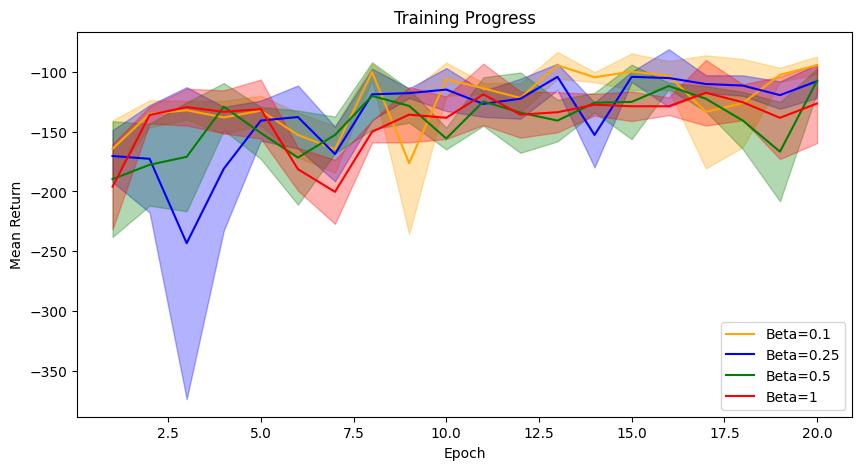

In [4]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = list(range(1, epochs + 1))
for i, beta in enumerate(betas):
    color = colors[i]
    ax1.set_ylabel("Mean Return")
    ax1.plot(x, mean_returns_betas[beta], color=color, label=f"Beta={beta}")
    ax1.fill_between(x, mean_returns_betas[beta] - std_returns_betas[beta], mean_returns_betas[beta] + std_returns_betas[beta], color=color, alpha=0.3)
    ax1.set_xlabel("Epoch")

plt.legend()
plt.title(f"Training Progress")

plt.savefig(f"DPO_ALL_{ENV_NAME}_{K}.jpg")

In [5]:
with open(f'DPO_DATA_ALL_DICT_{ENV_NAME}_{K}_MEAN.pkl', 'wb') as f:
    pickle.dump(mean_returns_betas, f)
with open(f'DPO_DATA_ALL_DICT_{ENV_NAME}_{K}_STD.pkl', 'wb') as f:
    pickle.dump(std_returns_betas, f)